# Análisis de Series Temporales con ARIMA: Temperaturas en Nueva York (1870-2020)

## Introducción
**El análisis de series temporales** es una herramienta fundamental en ciencia de datos, utilizada en diversas disciplinas como las finanzas, la meteorología y la economía. Su objetivo principal es identificar patrones en datos históricos y generar pronósticos precisos para la toma de decisiones. <br>
En este estudio, aplicaremos el modelo ARIMA (Autoregressive Integrated Moving Average), una metodología estadística ampliamente utilizada en el análisis de series temporales. Este modelo combina tres componentes esenciales.
1. AR (Autorregresivo): Captura relaciones entre valores pasados y presentes en la serie.
2. I (Integrado): Diferencia los datos para convertir la serie en estacionaria, eliminando tendencias.
3. MA (Promedios Móviles): Modela los efectos de errores previos en la serie.

### Objective
El propósito de este análisis es ajustar un modelo ARIMA óptimo para los datos de temperaturas promedio anuales en Nueva York durante el período 1870-2020.

### Los Datos
Los datos en este análisis corresponden a las temperaturas promedio anuales en Nueva York durante el período 1870-2020.

### Estructura
Para evaluar tendencias de temperatura a lo largo de los años y generar predicciones futuras, seguiremos los siguientes pasos:
1. Determinar la estacionariedad de la serie.
2. Transformar los datos aplicando diferencias si es necesario.
3. Seleccionar los mejores parámetros (p, d, q) del modelo ARIMA.
4. Generar pronósticos y evaluar la precisión del modelo.

Este análisis nos permitirá entender mejor la evolución de las temperaturas en Nueva York y evaluar la confiabilidad del modelo en el contexto del cambio climático.

## Método

### Importar Librerías

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller


### Cargar y Explorar los Datos

In [35]:
# Cargar los datos
df = pd.read_csv("data/TempNY.csv")
df.head()

,Year,Average,Unnamed: 2
0,1870,53.60,NaN
1,1871,51.13,NaN
2,1872,50.98,NaN
3,1873,50.98,NaN
4,1874,51.34,NaN


In [36]:
# Cambiamos el índice principal 
df.index = df["Year"]
df = df.drop("Year", axis = 1)

# Elimina columnas innecesarias 
df = df.drop(columns=["Unnamed: 2"], axis=1)
df.head()

,Average
Year,
1870,53.60
1871,51.13
1872,50.98
1873,50.98
1874,51.34


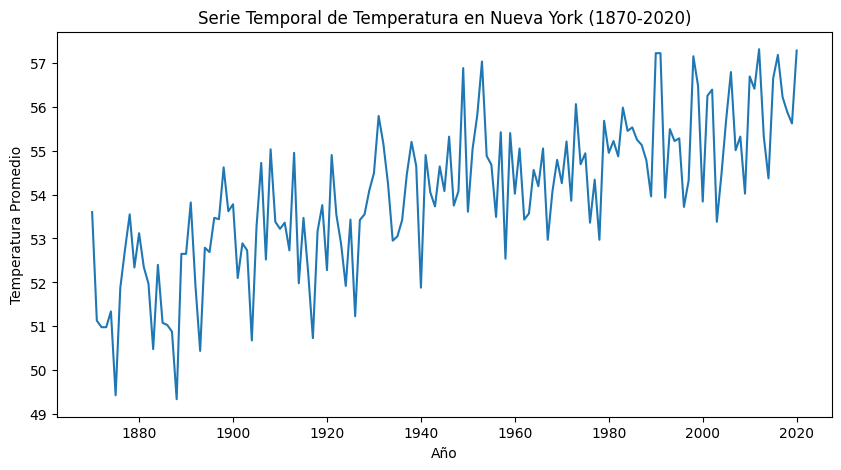

In [37]:
# Visualización de la serie temporal

# Graficamos la evolución de la temperatura a lo largo del tiempo
plt.figure(figsize=(10,5))
plt.plot(df["Average"], label="Temperatura promedio")
plt.title("Serie Temporal de Temperatura en Nueva York (1870-2020)")
plt.xlabel("Año")
plt.ylabel("Temperatura Promedio")
plt.show()


#### Comentario
Observamos una clara tendencia al alza en la temperatura a lo largo de los años, lo que sugiere un posible impacto del calentamiento global. <br>
También se nota que los datos muestran estacionariedad, dado que las características estadísticas parecen constante. Corroboraremos esta observación con la prueba de Dickey-Fuller.

### Prueba de Estacionariedad
Determina mediante la gráfica de prueba de Dickey-Fuller si los datos son estacionarios considerando una base de entrenamiento del 90% del total. En caso negativo, aplica tantas diferencias como sea necesario para alcanzar la estacionariedad.

In [ ]:
# Dividimos los datos en entrenamiento (90%) y prueba (10%)
train_size = int(len(df) * 0.9)
train_data = df.iloc[:train_size]

# Realizamos la prueba de Dickey-Fuller en los datos de entrenamiento
resultado = adfuller(train_data["Average"])
print("Estadístico de prueba:", resultado[0])
print("Valor p:", resultado[1])

# Si el valor p > 0.05, la serie no es estacionaria y aplicamos diferencias
d = 0
while resultado[1] > 0.05:
    d += 1
    train_data["Average"] = train_data["Average"].diff().dropna()
    resultado = adfuller(train_data["Average"])
    print(f"Diferenciación {d}: Estadístico de prueba: {resultado[0]}, Valor p: {resultado[1]}")

# Graficamos la serie transformada
plt.figure(figsize=(10, 5))
plt.plot(train_data["Average"], label="Serie transformada")
plt.title(f"Serie Transformada (Diferenciación {d})")
plt.xlabel("Año")
plt.ylabel("Temperatura Promedio")
plt.legend()
plt.show()

In [38]:
# Definición de grupos de prueba y entrenamiento
len_train = int(len(df) * 0.9)
len_test = int(len(df) * 0.1)
train = df[0:len_train]
test = df[len_train:]

In [39]:
# Realizamos la prueba de Dickey-Fuller para verificar si la serie es estacionaria
# Si el valor p > 0.05, la serie no es estacionaria y debe transformarse.
resultado = adfuller(train["Average"])
print("Valor p:", resultado[1])


Valor p: 0.42201206191181084


#### Comentario
El valor p > 0.05, lo que indica que la serie no es estacionaria. Hay que transformar los datos para continuar con la modelación.

### Transformación

In [40]:
# Aplicamos primeras diferencias
df["temp_change"] = df["Average"].diff()
df.head()

,Average,temp_change
Year,,
1870,53.60,NaN
1871,51.13,-2.47
1872,50.98,-0.15
1873,50.98,0.00
1874,51.34,0.36


In [41]:
# Elimina valor initial
df = df.dropna()
df.head()

,Average,temp_change
Year,,
1871,51.13,-2.47
1872,50.98,-0.15
1873,50.98,0.00
1874,51.34,0.36
1875,49.43,-1.91


In [42]:
# Aplicación de la prueba Dickey-Fuller sobre las diferencias
result2 = adfuller(df["temp_change"])
print("Valor p:", result2[1])

Valor p: 8.361907414786516e-14


#### Comentario
El valor p ha bajado mucho, hasta practicamente zero. Esto indica que la serie ya es estacionaria.

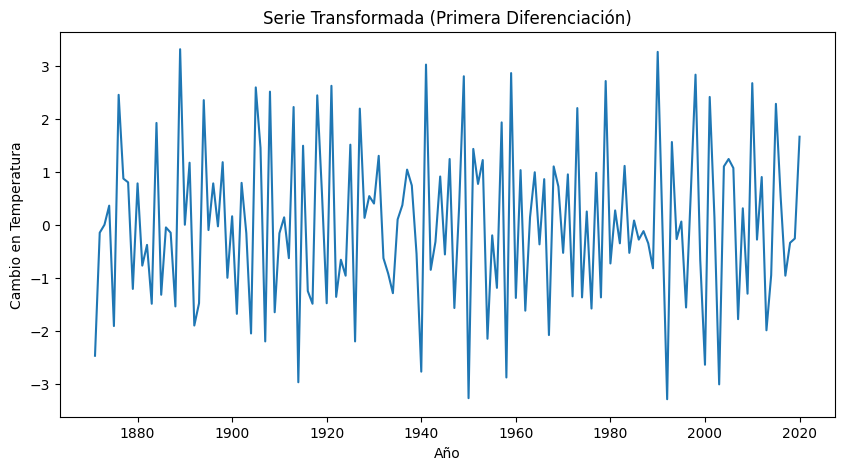

In [43]:
# Graficamos la serie transformada
plt.figure(figsize=(10,5))
plt.plot(df["temp_change"], label="Serie diferenciada")
plt.title("Serie Transformada (Primera Diferenciación)")
plt.xlabel("Año")
plt.ylabel("Cambio en Temperatura")
plt.show()


#### Conclusion
La serie transformada de diferencias si es estacionaria.

### Selección de Parámetros Mediante AIC
Identificar cuántos lags tienen autocorrelación significativa para definir los parámetros p y q. Elegimos el modelo con el menor valor de AIC como el óptimo.

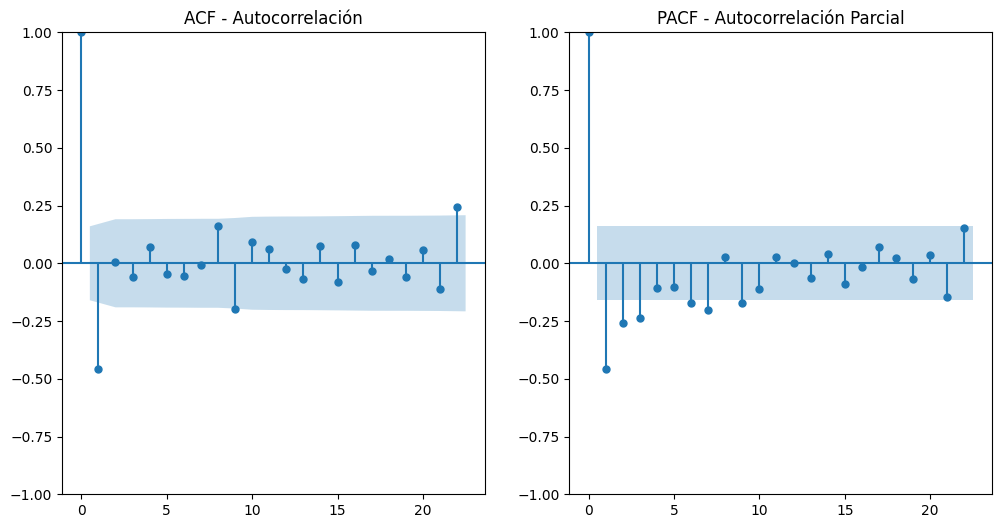

In [44]:
# Graficamos ACF y PACF para determinar p y q

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_acf(df["temp_change"].dropna(), ax=plt.gca())
plt.title("ACF - Autocorrelación")

plt.subplot(1,2,2)
plot_pacf(df["temp_change"].dropna(), ax=plt.gca())
plt.title("PACF - Autocorrelación Parcial")

plt.show()


#### Comentario
La gráfica ACF muestra la correlación significativa en el primer lag, y no correlación significativa en los anteriores, lo que indica un parámetro q óptimo de 1.
<br> <br>
La gráfica PACF también muestra la correlación significativa en el primer lag, y no correlación significativa en los anteriores, lo que indica un parámetro p óptimo de 1.
<br> <br>
Continuaremos con mas pruebas para verificar estos parámetros.

In [45]:
# Probamos varias combinaciones de p, d y q y calculamos el AIC
for p in range(0, 3):
    for q in range(0, 3):
        try:
            modelo = ARIMA(df["temp_change"], order=(p,1,q)).fit()
            print(f"ARIMA({p},1,{q}) - AIC: {modelo.aic}")
        except:
            continue


ARIMA(0,1,0) - AIC: 707.6818916517047
ARIMA(0,1,1) - AIC: 556.5137520870067
ARIMA(0,1,2) - AIC: 483.2644754218268
ARIMA(1,1,0) - AIC: 625.4419039622842
ARIMA(1,1,1) - AIC: 523.312165450822
ARIMA(1,1,2) - AIC: 484.0108719086778
ARIMA(2,1,0) - AIC: 594.5401983758172
ARIMA(2,1,1) - AIC: 514.384562545224
ARIMA(2,1,2) - AIC: 485.82070557104294


#### Conclusión
La serie de tiempo de temperaturas se modela bien con ARIMA(0,1,2).


### Ajuste del Modelo

In [46]:
mod = ARIMA(df['Average'], order=(0,1,2))
res = mod.fit()

print(res.summary())


                               SARIMAX Results                                
Dep. Variable:                Average   No. Observations:                  150
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -236.172
Date:                Sun, 04 May 2025   AIC                            478.343
Time:                        14:35:00   BIC                            487.355
Sample:                             0   HQIC                           482.005
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7999      0.088     -9.119      0.000      -0.972      -0.628
ma.L2         -0.0496      0.093     -0.534      0.594      -0.232       0.133
sigma2         1.3825      0.195      7.100      0.0

#### Comentario
Ya que el AIC fue más bajo para el modelo ARIMA(0,1,2), el resumen muestra que el coeficiente ma.L2 no es significativo (valor p > 0.05). Compararemos este modelo con ARIMA(0,1,1) para encontrar lo mejor.

In [47]:
from sklearn.metrics import mean_squared_error

# Ajustamos el modelo ARIMA(0,1,1)
mod_011 = ARIMA(df['Average'], order=(0,1,1))
res_011 = mod_011.fit()

# Ajustamos el modelo ARIMA(0,1,2)
mod_012 = ARIMA(df['Average'], order=(0,1,2))
res_012 = mod_012.fit()

# Comparación de AIC
print("AIC ARIMA(0,1,1):", res_011.aic)
print("AIC ARIMA(0,1,2):", res_012.aic)

# Comparación de valores p de los coeficientes
print("\nValores p ARIMA(0,1,1):")
print(res_011.pvalues)

print("\nValores p ARIMA(0,1,2):")
print(res_012.pvalues)

AIC ARIMA(0,1,1): 476.7543132664006
AIC ARIMA(0,1,2): 478.34337987261756

Valores p ARIMA(0,1,1):
ma.L1     6.628839e-65
sigma2    9.827795e-13
dtype: float64

Valores p ARIMA(0,1,2):
ma.L1     7.555499e-20
ma.L2     5.936201e-01
sigma2    1.246958e-12
dtype: float64


#### Conclusion
Al final, el modelo **ARIMA(0,1,1)** tiene AIC más bajo y todos sus coeficientes son significativos, así que es el modelo más adecuado.

### Predicciones

In [48]:
# Realizamos una predicción de los próximos valores usando el modelo ARIMA ajustado
predicciones = res_012.forecast(len(test))
predicciones

150    56.168526
151    56.098625
152    56.098625
153    56.098625
154    56.098625
155    56.098625
156    56.098625
157    56.098625
158    56.098625
159    56.098625
160    56.098625
161    56.098625
162    56.098625
163    56.098625
164    56.098625
165    56.098625
Name: predicted_mean, dtype: float64

In [49]:
# Convertir predicciones y test en DataFrames
predicciones_df = pd.DataFrame(predicciones)
test_df = pd.DataFrame(test)

# Preparar los DFs para la evaluación
test_df = test_df.reset_index()
predicciones_df = predicciones_df.reset_index()

In [50]:
test_df.head()

,Year,Average
0,2005,55.72
1,2006,56.79
2,2007,55.01
3,2008,55.32
4,2009,54.02


In [51]:
predicciones_df.head()

,index,predicted_mean
0,150,56.168526
1,151,56.098625
2,152,56.098625
3,153,56.098625
4,154,56.098625


### Evaluación del Modelo
Un RMSE bajo y un MAPE menor al 10% indican un modelo confiable.

In [52]:
acumulador1  = 0
acumulador2  = 0

for contador in range(len(test_df)):
    acumulador1 = acumulador1 + (test_df.iloc[contador][1] - predicciones_df.iloc[contador][1]) ** 2
    acumulador2 = acumulador2 + np.abs((test_df.iloc[contador][1] - predicciones_df.iloc[contador][1]) / 
                                       test_df.iloc[contador][1])
    
mse = acumulador1 / 101
rmse = np.round(np.sqrt(mse),2)
mape = np.round((acumulador2 / 101) * 100,2)

print("RMSE:", rmse, "\nMAPE:", mape, "%")

RMSE: 0.39 
MAPE: 0.24 %


#### Comentario
Según estos resultados, el modelo está capturando bien la estructura de los datos.

### Vizualización de Datos y Predicciones

In [53]:
# Generar predicciones puntuales e intervalos de confianza
forecast = res_011.get_forecast(steps=len(test))
forecast_index = test.index
forecast_mean = forecast.predicted_mean
conf = forecast.conf_int()

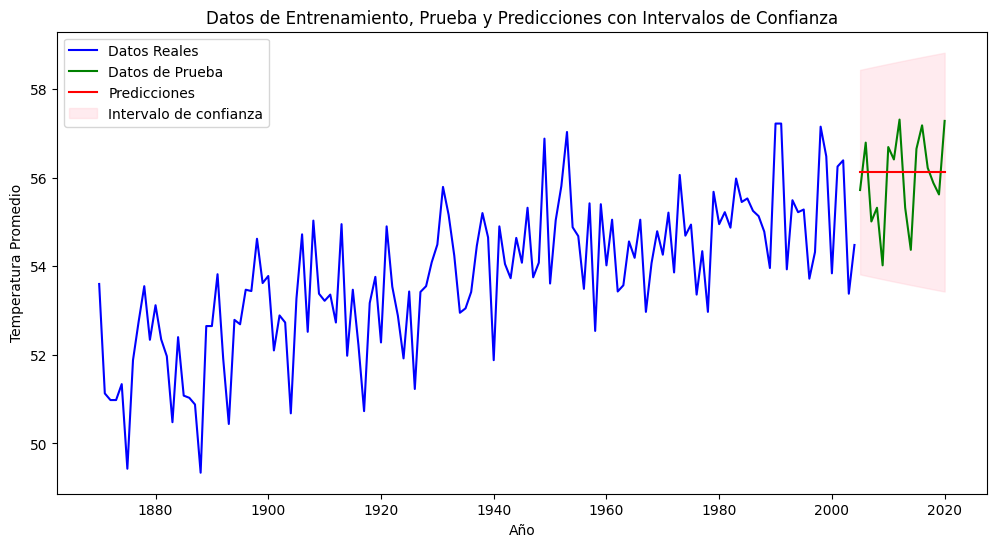

In [54]:
# Graficar los datos
plt.figure(figsize=(12, 6))

# Datos de entrenamiento
plt.plot(train.index, train["Average"], label="Datos Reales", color="blue")

# Datos de prueba
plt.plot(test.index, test["Average"], label="Datos de Prueba", color="green")

# Predicciones puntuales
plt.plot(forecast_index, forecast_mean, label="Predicciones", color="red")

# Intervalos de confianza
plt.fill_between(forecast_index, 
                 conf.iloc[:, 0], 
                 conf.iloc[:, 1], 
                 color="pink", alpha=0.3, label="Intervalo de confianza")

# Configuración de la gráfica
plt.title("Datos de Entrenamiento, Prueba y Predicciones con Intervalos de Confianza")
plt.xlabel("Año")
plt.ylabel("Temperatura Promedio")
plt.legend()
plt.show()

## Conclusión
### Resumen
Analizamos la serie temporal de temperaturas históricas utilizando el modelo ARIMA. Evaluamos modelos diferentes para encontrar lo más adecuado debido su menor AIC y significancia estadística.
<br><br>
Los resultados obtenidos muestran que el modelo es capaz de capturar patrones en los datos históricos y generar pronósticos con un nivel de precisión confiable, según las métricas de precisión usadas, RMSE y MAPE.

### Recomendaciones
Para mejorar este modelo, se recomienda explorar modelos más complejos y incorporar datos adicionales con factores externos que pueden capturar más variación en la serie.
